In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
# from model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Define environments with different variance structures

We construct a Mouselab-MDP with a symmetric tree structure by specifying a branching structure
and a function `reward(depth) -> Distribution` that specifies the reward distribution for
the nodes at each depth. The ground truth for each environment is determined when the `MouselabEnv`
object is instantiated. We can keep the ground truth constant by specifying a `seed` value. Each
env will have a different ground truth, but if we call `envs = make_envs(n=10, seed=1)` multiple times,
`env[4]` will always have the same ground truth.

In [25]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_envs(cost=1.00, n=100, seed=None,variance_structure="binary_tree_constant_high",branching=[2,2]):
    if seed is not None:
        np.random.seed(seed)
    
    depth = len(branching)
    
    if variance_structure is "binary_tree_constant_high":
        sigmas = np.concatenate( (np.array([0]),6*np.ones(depth)))
    if variance_structure is "binary_tree_increasing":
        sigmas = [0, 2, 20]
    if variance_structure is "binary_tree_decreasing":
        sigmas = [0,20,2]
    if variance_structure is "binary_tree_constant_low":
        sigmas = np.concatenate( (np.array([0]),3*np.ones(depth)))

    mu_R = 3

    def reward(depth):
        if depth > 0:
            return Normal(mu_R, sigmas[depth]).to_discrete(6).apply(int)
        return 0.

    envs = [MouselabEnv.new_symmetric(branching, reward)
            for _ in range(n)]
    for env in envs:
        env.cost=-cost
    
    return envs

def make_env(cost=1.00, seed=None,variance_structure="binary_tree_constant_high",branching=[2,2]):
    envs = make_envs(cost, 1, seed, variance_structure,branching)
    return envs[0]

# Save environments to JSON files

In [147]:
import json

def env_data(env):
    return {
        'trial_id': hash(env) % 100000000,
        'stateRewards': list(map(round,env.ground_truth)),
    }

cost = 1.00
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]
nr_environments = 1000

for env_type in environments:
    envs = make_envs(cost,nr_environments,None,env_type)

    with open('data/experiment_trials/'+env_type+'.json','w+') as f:
        json.dump(list(map(env_data, envs)), f)

# Compute the LC policy for each of these environments

In [26]:
from exact import solve
from contexttimer import Timer


#COSTS = [0.1,0.5, 1, 1.25, 2, 4]
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]
#environments = ["binary_tree_constant_high"]

Q = dict()
V= dict()
pi = dict()
info = dict()

cost = 1.00;
#for c in COSTS:
for env_type in environments:
    env = make_env(cost,None,env_type)#(cost=1.25, n=100, seed=None,variance_structure="constant_high"):
    Q[env_type], V[env_type], pi[env_type], info[env_type] = solve(envs[0])

#np.save('data/LC_weights_for_binary_trees.npy',weights)



In [27]:
Q["binary_tree_constant_high"](envs[0].init,1)

21.705739141911945

# Inspect LC policies

## Inspect LC policy for the environment with outward-increasing variance

In [99]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_increasing")

leaf_nodes = [2,3,5,6]
nr_leafs = len(leaf_nodes)

all_leafs= []
not_all_leafs=[]
nr_leafs_inspected = []
nr_nonleafs_inspected = []
nongoal_before_goal = []
first_click_on_goal = np.array([])

for env in envs:
    trace = run_episode(LC_policies["binary_tree_increasing"], env)
    all_leafs.append(np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    not_all_leafs.append(not np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_leafs_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonleafs_inspected.append(len(trace['actions'][:-1])- nr_leafs_inspected[-1])
    is_goal = np.in1d(trace['actions'][:-1],leaf_nodes)
    first_click_on_goal = np.append(first_click_on_goal,[is_goal[0]])
    if all_leafs[-1]:
        nongoal_before_goal.append(False)
    else:
        first_nongoal = np.where(is_goal == False)
        nongoal_before_goal.append(first_nongoal[0][0]<nr_leafs) 

In [100]:
print("Fraction of trials in which the first click inspected a goal: {}".format(np.mean(first_click_on_goal)))
print("Fraction of trials in which only goals were inspected: {}".format(np.mean(all_leafs)))
print("Fraction of trials in which a non-goal was inspected before all goals had been inspected: {}".format(np.mean(nongoal_before_goal)))

all_leafs_array = np.array(all_leafs)
nr_leafs_array = np.array(nr_leafs_inspected)
nr_nonleafs_array = np.array(nr_nonleafs_inspected)
np.mean(nr_leafs_array[~all_leafs_array])

print("Avg. number of leafs inspected when non-leafs were inspected: {}".format(np.mean(nr_leafs_array[~all_leafs_array])))
print("Avg. number of non-leafs inspected when any nonleafs were inspected: {}".format(np.mean(nr_nonleafs_array[~all_leafs_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["binary_tree_increasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

Fraction of trials in which the first click inspected a goal: 1.0
Fraction of trials in which only goals were inspected: 0.939
Fraction of trials in which a non-goal was inspected before all goals had been inspected: 0.001
Avg. number of leafs inspected when non-leafs were inspected: 4.0
Avg. number of non-leafs inspected when any nonleafs were inspected: 2.0
Example sequence: 
[2, 5, 6, 3, 7]
[3, 6, 2, 5, 4, 1, 7]


## Inspect Policy for environment with decreasing variance

In [233]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_decreasing")

leaf_nodes = [3,4,7,8,11,12,15,16]
stem_nodes = [1,5,9,13]
#branch_nodes = [2,6,10,14]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

for env in envs:
    trace = run_episode(LC_policies["binary_tree_decreasing"], env)
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
    

Fraction of trials in which only immediate outcomes were inspected: 0.771
Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: 0.0
Avg. number of immediate outcomes inspected when later outcomes were inspected: 4.0
Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: 4.637554585152839
Example sequence: 
[13, 17]


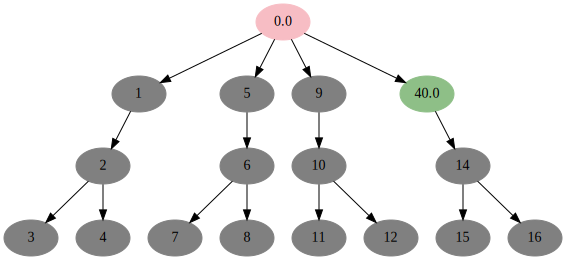

[13, 9, 5, 1, 17]


In [234]:
print("Fraction of trials in which only immediate outcomes were inspected: {}".format(np.mean(all_stems)))
print("Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: {}".format(np.mean(nonstem_before_stem)))


all_stems_array = np.array(all_stems)
nr_stems_array = np.array(nr_stems_inspected)
nr_nonstems_array = np.array(nr_nonstems_inspected)
np.mean(nr_stems_array[~all_stems_array])

print("Avg. number of immediate outcomes inspected when later outcomes were inspected: {}".format(np.mean(nr_stems_array[~all_stems_array])))
print("Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: {}".format(np.mean(nr_nonstems_array[~all_stems_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["binary_tree_decreasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

## Inspect policies for the environment with constant high variance

In [38]:
from policies import SoftmaxPolicy

nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_constant_high")

leaf_nodes = [2,3,5,6]
stem_nodes = [1,4]

nodes_by_depth=[stem_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_branch_nodes_inspected = []
nr_leaf_nodes_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations = []

nr_observations_by_branch = np.empty([nr_environments,4])

e=0
for env in envs:
    
    trace = run_episode(SoftmaxPolicy(Q["binary_tree_constant_high"]), env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_leaf_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))
    
    
    
    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    e+=1

The average number of observations was 0.00.
0.0
0.6725
0.54525
nan
nan
nan
Example sequence: 
[4, 6, 5, 1, 2, 3, 7]
[ 0.   0.5  0.   0.   0.5  0.   0.   0. ]
[ 0.   0.   0.   0.   0.   0.5  0.5  0. ]
[ 0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.   0.   0.5  0.5  0.   0.   0.   0. ]
[ 0.  0.  0.  1.  0.  0.  0.  0.]


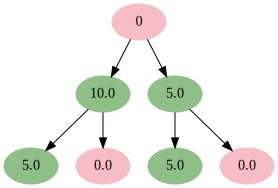

In [118]:
import time
print("The average number of observations was %.2f." % np.mean(nr_observations))

print(np.mean(all_stems))
print(np.mean(nr_stems_inspected)/len(stem_nodes))
print(np.mean(nr_leaf_nodes_inspected)/len(leaf_nodes))


print(np.mean(np.amax(nr_observations_by_branch,1)))
print(np.mean(np.amin(nr_observations_by_branch,1)))
print(np.mean(np.amax(nr_observations_by_branch,1)-np.amin(nr_observations_by_branch,1)))

pi=SoftmaxPolicy(Q["binary_tree_constant_high"])


print("Example sequence: ")
env = envs[41]

trace = run_episode(pi, env)

print(trace['actions'])
env.reset()

env.render()

t=0
for a in trace['actions'][0:-1]:
    env.step(a)
    print(pi.action_distribution(trace['states'][t]))
    env.render()
    #time.sleep(2)
    t+=1
env.render()
#print(trace['actions']) 

#np.save('data/case_study5.npy','env')

In [119]:
final_term_reward = []
nr_observations = []
for env in envs[0:100]:

    agent = Agent()
    agent.register(LC_policies['binary_tree_constant_high'])
    agent.register(env)
    trace = run_episode(LC_policies["binary_tree_constant_high"], env)
    #print(trace['actions'])

    env.reset()
    t=0
    for a in trace['actions'][0:-1]:
        env.step(a)
        #print(LC_policies['constant_high'].action_distribution(trace['states'][t]))
        #env.render()
        t+=1
    final_term_reward.append(env.expected_term_reward(trace['states'][t]))
    nr_observations.append(len(trace['actions'])-1)

In [120]:
term_rewards_array = np.array(final_term_reward)
nr_obs_array = np.array(nr_observations)
np.min(term_rewards_array[nr_obs_array<5])

#vals = np.linspace(-12+3, 12+3, 6)
#delta = vals[1] - vals[0]
#bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
#print(bins)

5.4237107971667946

## Case Study Protocols

### Case Study 1

### Case Study 2

### Case Study 3

### Case study 4

## Conclusion

In the 2-2 binary tree with sigma=6 all of the click sequences appear to be compatible with best-first search that starts with a non-leaf and then switches to leaf nodes afterwards. If it switches the branch after having fully explored one branch, it starts from the root.  This strategy appears to prune paths whose expected value is negative (env[30]: -4 on 1 and -4 on 5, then terminate).

If the strategy has an aspiration level, then it lies between 10 and 13. If the first leaf node was observed to be 0 then observing +10 on a leaf node is sufficient (aspiration level <=13). Without knowledge of the other branch, 5-5 is not sufficient (aspiration level >10).



This strategy is clearly distinct from traditional search strategies except for best-first search:

* It is distinct from breadth first search in that it will continue to explore the same branch if the node(s) observed on it are promising.
* It is distinct from depth-first search in that hops from branch to branch unless the observed value on a branch was really good.
* It doesn’t do backward search because it prefers nodes that are informative about multiple paths and leaf nodes are informative about only one single path. (edited)
* It might have a satisficing component to it.

## Qualitative predictions

1. The first observed node is never a leaf node.
1. If the first observed node is a non-leaf and its revealed value is above average (5 or 10), then people should inspect a leaf node on the same branch. But if the value is below average (0 or -4) then they should inspect a leaf node on a different branch.
1. People should not stop collecting information until they either find a path with an expected return that is at least 5.4 (slightly lower than the expected value).


## Inspect policy for the environment with constant low variance

In [112]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_constant_low")

leaf_nodes = [2,3,5,6]
stem_nodes = [1,4]
#branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations_by_branch = np.empty([nr_environments,2])

nr_observations = []
first_observation = []

e=0
for env in envs:
    trace = run_episode(LC_policies["binary_tree_constant_low"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    first_observation.append(trace['states'][1][trace['actions'][0]])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))    
    e+=1
        

In [113]:
np.max(nr_observations_by_branch[:,0:1])

3.0

In [114]:
first_observations_array = np.array(first_observation)
nr_observations_array = np.array(nr_observations)

print("The average number of observations was %.2f." % np.mean(nr_observations))

print("The maximum number of observations was {}".format(np.amax(nr_observations)))
print("The minimum number of observations was {}".format(np.amin(nr_observations)))

print("maximum number of observations on the same branch: {}".format(np.max(nr_observations_by_branch[:,0:1])))

print("Avg. first observation that led to termination: {}".format(np.mean(first_observations_array[nr_observations_array==1])))
print("Avg. first observation that led to continuation: {}:".format(np.mean(first_observations_array[nr_observations_array==2])))


#print("Zero observations: %.2f. percent" % 100*np.mean(np.equal(np.array(nr_observations),np.zeros([1000,1]))))
#print("One observation: %.2f. percent" % 100*np.mean(np.array(nr_observations)==1))
#print("Two observations: %.2f. percent" % 100*np.mean(np.array(nr_observations)==2))


print("Example sequence: ")
env=envs[0]
env.reset()
trace = run_episode(LC_policies["binary_tree_constant_low"], env)
print(trace['actions']) 


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 



The average number of observations was 1.79.
The maximum number of observations was 6
The minimum number of observations was 1
maximum number of observations on the same branch: 3.0
Avg. first observation that led to termination: 2.3527559055118106
Avg. first observation that led to continuation: -2.8876080691642656:
Example sequence: 
[4, 7]


# Measure the performance and number of clicks of the LC policies

In [124]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

term_action = 7

def eval_envs(cost, env_type, envs):
    policies = {
        'BO': LC_policies[env_type],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                df['env_type'] = env_type
                yield df
    return pd.concat(loop())


envs_per_type = 1000
chunks_per_job = 5
total_envs = envs_per_type * len(environments)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)

environments=['binary_tree_increasing','binary_tree_constant_low','binary_tree_constant_high']
#environments=['binary_tree_increasing']

cost = 1.00
jobs = [delayed(eval_envs)(cost, env_type, envs) 
        for env_type in environments
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost, envs_per_type,None, env_type))]
result = Parallel(n_job)(tqdm(jobs))

#Save results
results = pd.concat(result)
np.save('data/results_binary_trees.npy',results)


100%|██████████| 132/132 [00:22<00:00,  5.75it/s]

## Inspect the results

In [125]:
import pandas as pd
import numpy as np

#results=pd.DataFrame(np.load('data/results_binary_trees.npy'),columns=[''])

#results = np.load('data/results_variance_structures.npy')
#df = pd.DataFrame(list(results.item().iteritems()), columns=['agent','util','cost','env_type'])

#LC_policies.to_pickle('data/LC_policies_backward_planning.pkl')

#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','env_type']).util.mean())
print(results.groupby(['agent','env_type']).observations.mean())

#results

#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

agent             env_type                 
BO                binary_tree_constant_high    19.834867
                  binary_tree_constant_low      0.343407
                  binary_tree_increasing       16.726953
full-observation  binary_tree_constant_high    19.664000
                  binary_tree_constant_low     -2.148000
                  binary_tree_increasing       14.504000
none              binary_tree_constant_high    -0.148000
                  binary_tree_constant_low     -0.039600
                  binary_tree_increasing        0.072000
Name: util, dtype: float64
agent             env_type                 
BO                binary_tree_constant_high    4.740333
                  binary_tree_constant_low     1.794833
                  binary_tree_increasing       3.013367
full-observation  binary_tree_constant_high    6.000000
                  binary_tree_constant_low     6.000000
                  binary_tree_increasing       6.000000
none              binary_tree_consta

,observations,util,env,agent,cost,env_type
0,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
1,4,3.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
2,6,-16.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
3,4,36.800000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
4,1,27.000000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
5,6,-11.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
6,1,20.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
7,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
8,4,4.266667,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
9,6,-13.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing


In [55]:
results

,0,1,2,3,4,5
0,3,23.4,<MouselabEnv instance>,BO,1,increasing
1,4,24,<MouselabEnv instance>,BO,1,increasing
2,10,2,<MouselabEnv instance>,BO,1,increasing
3,8,18.4,<MouselabEnv instance>,BO,1,increasing
4,6,22,<MouselabEnv instance>,BO,1,increasing
5,10,2,<MouselabEnv instance>,BO,1,increasing
6,2,24.4,<MouselabEnv instance>,BO,1,increasing
7,3,25,<MouselabEnv instance>,BO,1,increasing
8,10,2,<MouselabEnv instance>,BO,1,increasing
9,5,21.4,<MouselabEnv instance>,BO,1,increasing
